In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
import numpy as np
import pickle

from IPython.core import debugger

In [1]:
FRESH = False

In [48]:
# To save as normal python script (easier to git diff)
!jupyter nbconvert --to script pipeline.ipynb

[NbConvertApp] Converting notebook pipeline.ipynb to script
[NbConvertApp] Writing 13580 bytes to pipeline.py


In [3]:
# TESTING
test_image_paths = glob.glob('test_images/test*.jpg')
test_images = [cv2.imread(file) for file in test_image_paths]
# test_images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in test_images]

# pipeline(test_images[0], calibration, M)

In [6]:
if FRESH:
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(9,6,0)
    cal_x = 9
    cal_y = 6
    objp = np.zeros((cal_x*cal_y,3), np.float32)
    objp[:,:2] = np.mgrid[0:cal_x, 0:cal_y].T.reshape(-1,2)

    # Prepare the object points and image points for the calibration
    calibration_image_paths = glob.glob('camera_cal/calibration*.jpg')
    calibration_images = [cv2.imread(file) for file in calibration_image_paths]
    calibration_images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in calibration_images]

    obj_points = []
    img_points = []
    for gray in calibration_images_gray:
        ret, corners = cv2.findChessboardCorners(gray, (cal_x,cal_y), None)
        if ret:
            obj_points.append(objp)
            img_points.append(corners)

    img_size = (calibration_images_gray[0].shape[1],
                calibration_images_gray[0].shape[0])

    # Calibrate the camera (and save pickle)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    calibration = {
        "ret": ret,
        "mtx": mtx,
        "dist": dist,
        "rvecs": rvecs,
        "tvecs": tvecs
    }
    pickle.dump(calibration, open("camera_cal/pickled_calibration.p", "wb"))
else:
    calibration = pickle.load(open("camera_cal/pickled_calibration.p", "wb"))

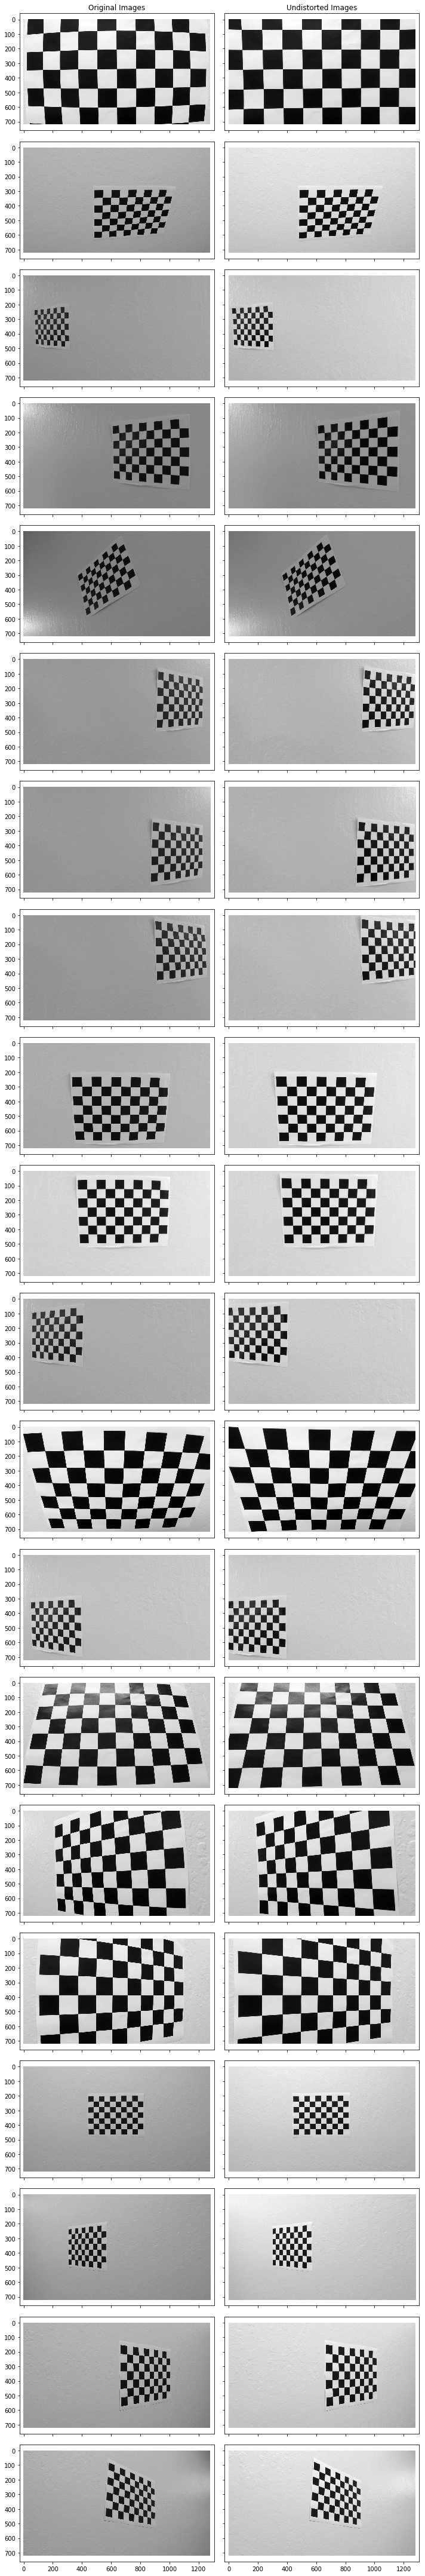

In [7]:
if FRESH:
    undistorted_images = [cv2.undistort(img, mtx, dist, None, mtx) for img in calibration_images_gray]

    # Visualize undistortion
    f, axes = plt.subplots(len(calibration_images), 2, figsize=(10,60), sharey=True, sharex=True)

    for i, (org, undist) in enumerate(zip(calibration_images_gray, undistorted_images)):
        axes.flat[2*i].imshow(calibration_images_gray[i], cmap='gray')
        axes.flat[2*i + 1].imshow(undistorted_images[i], cmap='gray')

        if i == 0:
            axes.flat[i].set_title('Original Images')
            axes.flat[i+1].set_title('Undistorted Images')
            cv2.imwrite('output_images/original_chessboard.jpg', org)
            cv2.imwrite('output_images/undistorted_chessboard.jpg', undist)

    plt.tight_layout()

In [8]:
# Thresholding functions

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise ValueError('Unrecognised orient {}'.format(orient))

    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    grad_binary = ((scaled >= thresh[0]) & (scaled <= thresh[1])).astype(int)
    return grad_binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobel_xy_abs = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled = np.uint8(255 * sobel_xy_abs / np.max(sobel_xy_abs))

    mag_binary = ((scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])).astype(int)
    return mag_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    grad = np.arctan2(sobely_abs, sobelx_abs)

    dir_binary = ((grad >= thresh[0]) & (grad <= thresh[1]))
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_output = (hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])
    return binary_output

In [9]:
# Constants for actual use of above functions
# Choose a Sobel kernel size
KSIZE = 3 # Choose a larger odd number to smooth gradient measurements

# Function which combines above threshold methods
def threshold_combination(img, plot=False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=KSIZE, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=KSIZE, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=KSIZE, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=KSIZE, thresh=(0.7, 1.3))

    # combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined = (gradx & grady | mag_binary & dir_binary)
    
    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(combined, cmap='gray')
        ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

    return combined

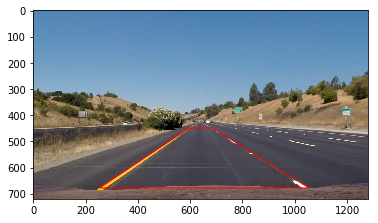

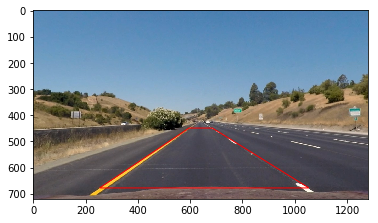

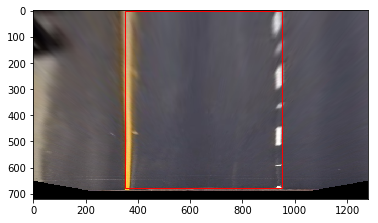

In [10]:
straight = cv2.imread('test_images/straight_lines1.jpg')
straight = cv2.cvtColor(straight, cv2.COLOR_BGR2RGB)

# SRC points determined from manual inspection of straight line image
# XXX - should I be choosing points from the undistorted image?
src_points = np.float32([
    [596, 449], # top-left
    [685, 449], # top-right
    [1054, 678], # bottom-right
    [254, 678] # bottom-left
])
destination_points = np.float32([
#     [266, -1000], # top-left
#     [1054, -1000], # top-right
#     [254, 0], # top-left
#     [1054, 0], # top-right
#     [1054, 678], # bottom-right
#     [254, 678] # bottom-left
    [350, 0], # top-left
    [950, 0], # top-right
    [950, 678], # bottom-right
    [350, 678] # bottom-left
])

plt.imshow(straight)
# for pt in src_points:
#     plt.plot(*pt, '.')
plt.gca().add_patch(Polygon(src_points, linewidth=1,edgecolor='r',facecolor='none'))
# Calculate the perspective transform matrix M
M = cv2.getPerspectiveTransform(src_points, destination_points)
# Get the inverse perspective transform
M_inv = cv2.getPerspectiveTransform(destination_points, src_points)


straight_undist = cv2.undistort(straight, calibration['mtx'], calibration['dist'], None, calibration['mtx'])
plt.figure()
plt.imshow(straight_undist)
plt.gca().add_patch(Polygon(src_points, linewidth=1,edgecolor='r',facecolor='none'))
straight_warped = cv2.warpPerspective(straight_undist, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(straight_warped)
plt.gca().add_patch(Polygon(destination_points, linewidth=1,edgecolor='r',facecolor='none'))
# def transform_perspective(img, M):
#     return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

In [46]:
# Windows (2 methods)
MIN_PIXELS = 50

n_windows = 9
W_WIDTH = 50
w_height = 90
MARGIN = 100

# Function which finds indices of lane (will call twice e.g. for left/right)
def find_lane_indices_from_windows(binary_img, start_x, nonzero_x, nonzero_y):
    img_shape = binary_img.shape
    w_centre = start_x
    pixels = []
    window_history = []

    for n in range(n_windows):
        w_bottom = img_shape[0] - n*w_height
        w_top = w_bottom - w_height

        # Identify non-zero pixels within the window
        nonzero_pixels = (
            (nonzero_y >= w_top) & 
            (nonzero_y < w_bottom) & 
            (nonzero_x >= w_centre - W_WIDTH / 2) & 
            (nonzero_x < w_centre + W_WIDTH / 2)
        ).nonzero()[0]
        
        pixels.append(nonzero_pixels)
        
        # If sufficient non-zero pixels are found then renceter next window
        # on the mean position of the non-zero pixels
        if len(nonzero_pixels)>= MIN_PIXELS:
            w_centre = np.int(np.mean(nonzero_x[nonzero_pixels]))
    
    return np.concatenate(pixels)


def find_lane_indices_from_fit(fit, nonzero_x, nonzero_y):
    # Identify the x and y positions of all nonzero pixels in the image
    line = fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2]
    lane_inds = ((nonzero_x > line - margin) & 
                 (nonzero_x > line + margin))
    return lane_inds


def get_start_points_using_histogram(binary_img):
    img_height, img_width = binary_img.shape

    histogram = np.sum(binary_img[int(img_height/2):, :], axis=0)
    plt.plot(histogram)
    plt.figure()
    
    # Get the start points for the windows (e.g. bottom of lane lines)
    midpoint = int(img_width / 2)
    left_start = np.argmax(histogram[:midpoint])
    right_start = midpoint + np.argmax(histogram[midpoint:])
    return left_start, right_start


def get_line_fits(binary_img, prev_left_fit=None, prev_right_fit=None):
    """
    If we have the previous line information (e.g. from previous frame in video):
        Use this to find the pixels which make up the new line.
    Else:
        Use the histogram to find the base of the lines and the window method
        to find the rest of the line

    Return the best fit through the pixels
    """
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    if prev_left_fit is None or prev_right_fit is None:
        left_start, right_start = get_start_points_using_histogram(binary_img)
        print(left_start, right_start)
    
    if prev_left_fit is None:
        left_lane_inds = find_lane_indices_from_windows(binary_img, left_start, nonzero_x, nonzero_y)
    else:
        left_lane_inds = find_lane_indices_from_fit(prev_left_fit, nonzero_x, nonzero_y)

    if prev_right_fit is None:
        right_lane_inds = find_lane_indices_from_windows(binary_img, right_start, nonzero_x, nonzero_y)
    else:
        right_lane_inds = find_lane_indices_from_fit(prev_right_fit, nonzero_x, nonzero_y)

    # Extract left and right line pixel positions
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds]
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if True:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        out_img = np.dstack((binary_img, binary_img, binary_img))*255
        out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
        out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return left_fit, right_fit


In [12]:
# 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
# DONE
# 2. Apply a distortion correction to raw images.
# DONE
# 3. Use color transforms, gradients, etc., to create a thresholded binary image.
# IMPLEMENTED BUT NOT FINISHED
# 4. Apply a perspective transform to rectify binary image ("birds-eye view").
# DONE
# 5. Detect lane pixels and fit to find the lane boundary.
# 6. Determine the curvature of the lane and vehicle position with respect to center.
# 7. Warp the detected lane boundaries back onto the original image.
# 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

def pipeline(img, calibration, M):
#     img_size = 
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Not sure I need this?
    undistorted_img = cv2.undistort(img, calibration['mtx'], calibration['dist'], None, calibration['mtx'])
    threshold_binary = threshold_combination(undistorted_img)
#     warped_binary = cv2.warpPerspective(threshold_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    

In [13]:
# Takes the result of the pipeline and visualises it
def visualisation():
    pass

Text(0.5,1,'Warped Threshold')

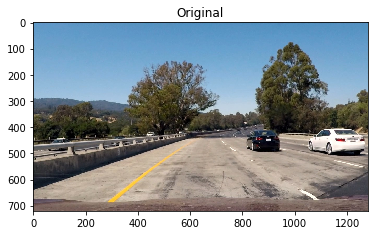

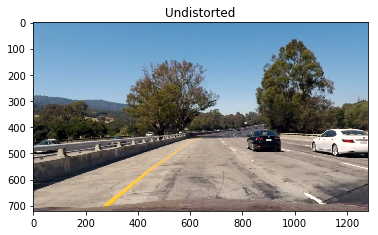

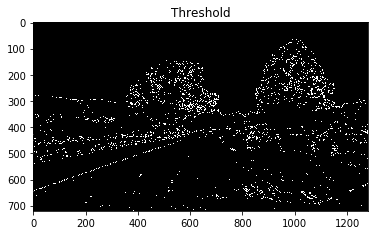

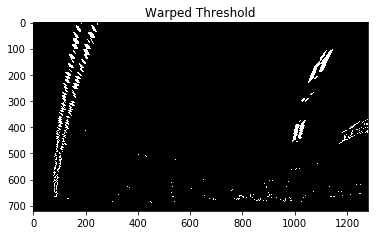

In [14]:
test = test_images[0]
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)
plt.title('Original')

test_undist = cv2.undistort(test, calibration['mtx'], calibration['dist'], None, calibration['mtx'])
plt.figure()
plt.imshow(test_undist)
plt.title('Undistorted')

threshold_binary = threshold_combination(test_undist, False)
plt.figure()
plt.imshow(threshold_binary, cmap='gray')
plt.title('Threshold')

warped_binary = cv2.warpPerspective(np.uint8(threshold_binary), M, img_size, flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(warped_binary, cmap='gray')
plt.title('Warped Threshold')

In [15]:
# Useful to remember
# threshold_binary_2 = threshold_binary[:,:,None]
# threshold_3 = np.dstack((np.zeros_like(threshold_binary), np.zeros_like(threshold_binary), threshold_binary)) * 255

90 1002


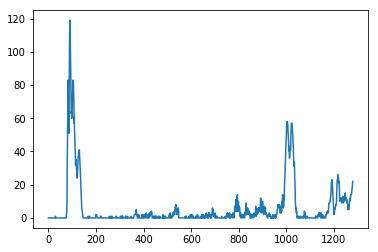

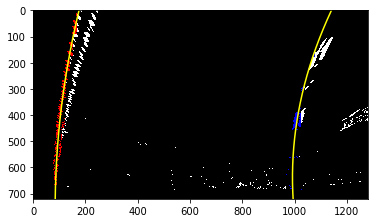

In [47]:
left_fit, right_fit = get_line_fits(warped_binary)